In [1]:
import sys
from pathlib import Path
import subprocess
import os
import gc
from glob import glob
from datetime import datetime
import json
from os import listdir

import polars as pl
import numpy as np
import pandas as pd
import polars.selectors as cs
from polars.type_aliases import IntoExpr

import seaborn as sns
import matplotlib.pyplot as plt
from typing import Callable, Iterable, Iterator
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.4f}'.format)

pl.Config.set_fmt_float("full")
pl.Config.set_float_precision(4)

RAND = 10

In [2]:
ROOT = f"../"
TRAIN_DIR = f"{ROOT}parquet_files/train"
TEST_DIR = f"{ROOT}parquet_files/test"

# Overview

Данные взяты из соревания на Kaggle. Основная информация по данным представлена здесь https://www.kaggle.com/competitions/home-credit-credit-risk-model-stability/data

Цель - предсказать, какие клиенты с большей вероятностью не смогут выплатить свои кредиты. Оценка должна быть стабильна с течением времени

Основные колонки:
- case_id -  уникальный идентификатор для каждого кредитного кейса. Этот идентификатор понадобится вам для объединения соответствующих таблиц с базовой таблицей.
- date_decision -  дата, когда было принято решение об одобрении кредита.
- WEEK_NUM - номер недели, используемый для агрегирования. Будет использоваться в оценке стабильности по Джини
- **target - целевое значение, определяемое по истечении определенного периода времени в зависимости от того, допустил ли клиент дефолт по конкретному кредитному делу (займу).**
- num_group1 - столбец индексации, используемый для исторических записей case_id как в таблицах depth=1, так и в таблицах depth=2..
- num_group2 - второй столбец индексации для исторических записей case_id в таблицах depth=2. Порядок следования num_group 1 и num_group2 важен и будет уточнен в определениях объектов.

Определения всех остальных столбцов можно найти в файле feature_definitions.csv. Для таблиц с глубиной=0 (depth=0) записи можно напрямую использовать в качестве фич. Однако для таблиц с глубиной > 0 (depth=1,2) потребуется использовать функции агрегирования, которые будут объединять исторические записи, связанные с каждым case_id, в единый объект. В случае, если num_group 1 или num_group2 обозначает индекс пользователя (это ясно из определений фичи), нулевой индекс имеет особое значение. Когда num_groupN=0, это заявитель (лицо, подавшее заявку на получение кредита).

Для загрузки и предобработки данных будем использовать polars, т.к. файлы большие и данных много

# Preprocessing

При загрузке будем конвертировать данные, согласно приведенному описанию.

Признаки были преобразованы, есть следующие обозначения для сходных групп преобразований:
- P - Преобразование DPD (просроченных дней)
- M - Маскировка категорий
- A - Преобразование сумм
- D - Преобразование дат
- T, L - Прочие преобразования

Преобразования внутри группы обозначаются заглавной буквой в конце имени предиктора.

In [3]:
def set_table_dtypes(df: pl.DataFrame,
                     columns_dtypes: dict = None) -> pl.DataFrame:
    """
    Set dtypes for dataframe columns.

    Last letter of column name determine the type.
    """
    int_patterns = [
        "num", "cnt", "quantity", "days", "count", "_month", "_year", "today"
    ]
    numeric_patterns = [
        "quarter", "year", "month", "amount", "rate", "transactions", "week",
        "sum", "pct"
    ]

    int_columns = [
        "case_id",
        "WEEK_NUM",
        "num_group1",
        "num_group2",
        "applications30d_658L",
        "tenor_203L",
    ]
    float_columns = [
        "eir_270L", "riskassesment_940T", "byoccupationinc_3656910L"
    ]

    for col in df.columns:
        if columns_dtypes and col in columns_dtypes():
            column_dtype = columns_dtypes[col]
        elif col in int_columns:
            column_dtype = pl.Int64
        elif col in float_columns:
            column_dtype = pl.Float64
        elif col in ["date_decision"]:
            column_dtype = pl.Date
        elif col[-1] in ("P"):
            column_dtype = pl.Int64
        elif col[-1] in ("A"):
            column_dtype = pl.Float64
        elif col[-1] == "M":
            column_dtype = pl.String
        elif col[-1] == "D":
            column_dtype = pl.Date
        elif col[-1] in ("T", "L"):
            if col.startswith("for"):
                column_dtype = pl.Int64
            elif any(s in col for s in int_patterns):
                column_dtype = pl.Int64
            elif any(s in col for s in numeric_patterns):
                column_dtype = pl.Float64
            else:
                column_dtype = pl.String
        df = df.with_columns(pl.col(col).cast(column_dtype).alias(col))
    return df

- Будем поэтапно загружать данные из файлов, аггрегировать данные и объединять с базовой таблицей
- Обработаем даты     
    - даты рождения переведем в возраст
    - для остальных дат рассчитаем количество дней по формуле: date_decision - дата

In [4]:
def read_files(regex_path: str,
               columns: list[str] = None,
               filter_expr: IntoExpr = None,
               group_by_expr: Iterable[IntoExpr] = None,
               sort_by: str = None,
               drop_columns: list[str] = None) -> pl.DataFrame:
    """
    Read files and combine dataframes

    Parameters
    ----------
    regex_path: str
        pathname pattern

    columns: list[str]
        a list of column names columns to select

    filter_expr: IntoExpr    
        Expression to filter DataFrame

    group_by_expr: Iterable[IntoExpr]
        Expression(s) to aggregate the data after groupping DataFrame

    drop_columns: list[str]
        a list of column names columns to drop 

    Returns
    -------
    Combined DataFrame
    """
    chunks = []

    for path in glob(str(regex_path)):
        df = pl.read_parquet(path, columns=columns)
        df = df.pipe(set_table_dtypes)
        if sort_by:
            df = df.sort(sort_by)
        if filter_expr is not None:
            df = df.filter(filter_expr)
        if drop_columns:
            df = df.drop([col for col in drop_columns if col in df.columns])
        if group_by_expr:
            df = df.group_by("case_id").agg(group_by_expr(df))

        chunks.append(df)

    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])
    return df


def merge_data(df_base: pl.DataFrame,
               regex_path: str,
               columns: list[str] = None,
               filter_expr: IntoExpr = None,
               group_by_expr: Iterable[IntoExpr] = None,
               sort_by: str = None,
               drop_columns: list[str] = None) -> pl.DataFrame:
    """
    Merge data df_base with data loaded from regex_path.
    """
    print(f"Processing file {regex_path}")

    df = read_files(regex_path, columns, filter_expr, group_by_expr, sort_by,
                    drop_columns)
    df = df_base.join(df, how="left", on="case_id")
    return df

In [5]:
def handle_dates(df: pl.DataFrame):
    """
    Hanles dates in data.
    
    Converts dates to the number of days or year for ages.
    """
    for col in df.columns:
        if col[-1] == "D":
            df = df.with_columns(
                (pl.col("date_decision") - pl.col(col)).alias(col))
            df = df.with_columns(pl.col(col).dt.total_days())
            if "birth" in col:
                df = df.with_columns((pl.col(col) // 365).cast(pl.Int64))

        if any(s in col for s in ["maxdateyear", "_year_"]):
            df = df.with_columns(((pl.col("date_decision").dt.year() -
                                   pl.col(col)).cast(pl.Int64)).alias(col))

    df = (df.with_columns(
        month_decision=pl.col("date_decision").dt.month(),
        weekday_decision=pl.col("date_decision").dt.weekday()))
    df = df.drop("date_decision")

    return df


def get_deposit_exprs(df: pl.DataFrame) -> Iterable[IntoExpr]:
    """
    Returns the expressions for aggregatin data in groups for deposit data
    """
    exprs = []
    for col in df.columns:
        if col == "amount_416A":
            exprs.append(pl.last(col).alias(f"last_{col}"))
            exprs.append(pl.max(col).alias(f"max_{col}"))
        elif col[-1] == "D":
            exprs.append(pl.last(col).alias(f"last_{col}"))
    return exprs


def get_columns_exprs(df: pl.DataFrame) -> Iterable[IntoExpr]:
    """
    Returns the expressions for aggregatin data in groups
    """
    year_patterns = ["maxdateyear", "_year_"]
    exprs = []
    for col in df.columns:
        if col[-1] == "D":
            exprs.append(pl.max(col).alias(f"max_{col}"))
        elif col[-1] == "A":
            exprs.append(pl.mean(col).alias(f"mean_{col}"))
        elif col[-1] == "P":
            exprs.append(pl.mean(col).cast(pl.Int64).alias(f"mean_{col}"))
        elif col[-1] == "M":
            exprs.append(pl.col(col).mode().first().alias(f"mode_{col}"))
        elif col[-1] in ("T", "L"):
            if "month" in col:
                exprs.append(pl.max(col).cast(pl.Int64).alias(f"max_{col}"))
            elif any(s in col for s in year_patterns):
                exprs.append(pl.max(col).cast(pl.Int64).alias(f"max_{col}"))
            elif df[col].dtype in pl.NUMERIC_DTYPES:
                exprs.append(pl.mean(col).alias(f"mean_{col}"))
            else:
                exprs.append(pl.col(col).mode().first().alias(f"mode_{col}"))
        elif "num_group" in col:
            exprs.append(pl.count(col).alias(f"count_{col}"))
    return exprs

In [6]:
def load_data(files_pattern: str) -> pl.DataFrame:
    """
    Loads all the data and combines it into a single table 
    """
    df = read_files(f"{files_pattern}base.parquet")
    df = df.drop("MONTH")
    df = df.pipe(set_table_dtypes)

    files_depth_0 = ["static_0_*.parquet", "static_cb_0*.parquet"]

    files_depth_1 = [
        "applprev_1_*.parquet", "other_1.parquet", "tax_registry_a_1.parquet",
        "tax_registry_b_1.parquet", "tax_registry_c_1.parquet",
        "credit_bureau_a_1_*.parquet", "credit_bureau_b_1.parquet",
        "debitcard_1.parquet"
    ]

    for file in files_depth_0:
        df = merge_data(df, f"{files_pattern}{file}")

    for file in files_depth_1:
        df = merge_data(df,
                        f"{files_pattern}{file}",
                        group_by_expr=get_columns_exprs,
                        drop_columns=["num_group1"])

    df = merge_data(df,
                    f"{files_pattern}deposit_1.parquet",
                    group_by_expr=get_deposit_exprs,
                    sort_by="num_group1",
                    drop_columns=["num_group1"])

    df = merge_data(df,
                    f"{files_pattern}person_1.parquet",
                    filter_expr=pl.col("num_group1") == 0,
                    drop_columns=["num_group1"])

    df = merge_data(df,
                    f"{files_pattern}applprev_2.parquet",
                    columns=["case_id", "cacccardblochreas_147M"],
                    group_by_expr=get_columns_exprs)

    df = merge_data(
        df,
        f"{files_pattern}person_2.parquet",
        columns=["case_id", "empls_economicalst_849M", "num_group1"],
        filter_expr=pl.col("num_group1") == 0,
        group_by_expr=get_columns_exprs,
        drop_columns=["num_group1"])

    df = merge_data(df,
                    f"{files_pattern}applprev_2.parquet",
                    columns=["case_id", "cacccardblochreas_147M"],
                    group_by_expr=get_columns_exprs)

    df = merge_data(df,
                    f"{files_pattern}credit_bureau_a_2_*.parquet",
                    group_by_expr=get_columns_exprs,
                    drop_columns=["num_group1", "num_group2"])

    df = merge_data(
        df,
        f"{files_pattern}credit_bureau_b_2.parquet",
        columns=["case_id", "pmts_dpdvalue_108P", "pmts_pmtsoverdue_635A"],
        group_by_expr=get_columns_exprs)

    df = df.pipe(handle_dates)

    return df

- Для оптимизации использования памяти будем удалять столбцы, несущие мало полнезной информации: содержащие много нулей, содержащие только одно значение, стороковые стобцы с большим количеством уникальных значений 

In [7]:
def filter_columns_with_nulls(df: pl.DataFrame,
                              threshold: float = 0.9,
                              true_df_threshold: float = 0.95) -> pl.DataFrame:
    """
    Filter out columns with nulls greater than the specified threshold
    """

    true_df = df.filter(pl.col("target") == 1)
    true_df_size = true_df.shape[0]
    df_size = df.shape[0]
    columns_to_drop = []
    for col in df.columns:
        is_null = df[col].null_count() / df_size
        if is_null > threshold:
            is_null_true_df = true_df[col].null_count() / true_df_size
            if is_null_true_df > true_df_threshold:
                columns_to_drop.append(col)
                print(
                    f"column to drop: {col}, is_null (all dataset):{is_null}, is_null(target=1):{is_null_true_df}"
                )

    if (any(columns_to_drop)):
        df = df.drop(columns_to_drop)
        print(f"dropped columns count: {len(columns_to_drop)}")
    return df


def filter_columns_by_frequency(
        df: pl.DataFrame,
        min_threshold: int = 1,
        max_threshold: int = 200,
        frequency_threshold: float = 0.99
    ) -> pl.DataFrame:
    """
    Filter out columns by count of unique values and their frequency
    """
    
    columns_to_drop = []    
    rows_count = df_train.shape[0]
    
    for col in df.columns:
        n_unique = df[col].n_unique()
        is_null = df[col].null_count() / df.shape[0]
        
        # Also check when None values in n_unique
        if n_unique == min_threshold or (n_unique == (min_threshold + 1)
                                         and is_null > 0):
            columns_to_drop.append(col)
            print(f"column to drop: {col}, n_unique:{n_unique}")
        elif (df[col].dtype == pl.String) and (n_unique > max_threshold):
            columns_to_drop.append(col)
            print(f"column to drop: {col}, n_unique:{n_unique}")
        else:
            cnts = df_train[col].value_counts() 
            top_count = cnts["count"].max() / rows_count
            if top_count > frequency_threshold:
                columns_to_drop.append(col)
                print(f"column to drop: {col}, top_count:{top_count}")

    if (any(columns_to_drop)):
        df = df.drop(columns_to_drop)
        print(f"dropped columns count: {len(columns_to_drop)}")

    return df

## Train data

In [8]:
df_train = load_data(f"{TRAIN_DIR}/train_")
df_train = (df_train
                .pipe(filter_columns_with_nulls)
                .pipe(filter_columns_by_frequency)
           )
print(f"Train size: {df_train.shape}")

Processing file ../parquet_files/train/train_static_0_*.parquet
Processing file ../parquet_files/train/train_static_cb_0*.parquet
Processing file ../parquet_files/train/train_applprev_1_*.parquet
Processing file ../parquet_files/train/train_other_1.parquet
Processing file ../parquet_files/train/train_tax_registry_a_1.parquet
Processing file ../parquet_files/train/train_tax_registry_b_1.parquet
Processing file ../parquet_files/train/train_tax_registry_c_1.parquet
Processing file ../parquet_files/train/train_credit_bureau_a_1_*.parquet
Processing file ../parquet_files/train/train_credit_bureau_b_1.parquet
Processing file ../parquet_files/train/train_debitcard_1.parquet
Processing file ../parquet_files/train/train_deposit_1.parquet
Processing file ../parquet_files/train/train_person_1.parquet
Processing file ../parquet_files/train/train_applprev_2.parquet
Processing file ../parquet_files/train/train_person_2.parquet
Processing file ../parquet_files/train/train_applprev_2.parquet
Processin

column to drop: applicationcnt_361L, top_count:0.9999908296482711
column to drop: bankacctype_710L, n_unique:2
column to drop: clientscnt_257L, top_count:0.9971198545320206
column to drop: clientscnt_360L, top_count:0.9970536969945483
column to drop: clientscnt_493L, top_count:0.9937523703721656
column to drop: commnoinclast6m_3546845L, n_unique:2
column to drop: deferredmnthsnum_166L, n_unique:1
column to drop: isdebitcard_729L, n_unique:2
column to drop: lastapprcommoditytypec_5251766M, n_unique:214
column to drop: lastrejectcommodtypec_5251769M, top_count:0.9916078181178639
column to drop: mastercontrelectronic_519L, n_unique:2
column to drop: mastercontrexist_109L, n_unique:2
column to drop: paytype1st_925L, n_unique:2
column to drop: paytype_783L, n_unique:2
column to drop: previouscontdistrict_112M, n_unique:223
column to drop: typesuite_864L, n_unique:2
column to drop: mode_district_544M, n_unique:597
column to drop: mode_profession_152M, n_unique:1515
column to drop: mode_name_

## Test data

In [9]:
df_test = load_data(f"{TEST_DIR}/test_")
df_test = df_test.select([col for col in df_train.columns if col != "target"])
print(f"Test size: {df_test.shape}")

Processing file ../parquet_files/test/test_static_0_*.parquet
Processing file ../parquet_files/test/test_static_cb_0*.parquet
Processing file ../parquet_files/test/test_applprev_1_*.parquet
Processing file ../parquet_files/test/test_other_1.parquet
Processing file ../parquet_files/test/test_tax_registry_a_1.parquet
Processing file ../parquet_files/test/test_tax_registry_b_1.parquet
Processing file ../parquet_files/test/test_tax_registry_c_1.parquet
Processing file ../parquet_files/test/test_credit_bureau_a_1_*.parquet
Processing file ../parquet_files/test/test_credit_bureau_b_1.parquet
Processing file ../parquet_files/test/test_debitcard_1.parquet
Processing file ../parquet_files/test/test_deposit_1.parquet
Processing file ../parquet_files/test/test_person_1.parquet
Processing file ../parquet_files/test/test_applprev_2.parquet
Processing file ../parquet_files/test/test_person_2.parquet
Processing file ../parquet_files/test/test_applprev_2.parquet
Processing file ../parquet_files/test/t

## Final

In [10]:
def to_pandas(df: pl.DataFrame, int_columns: list[str]) -> pd.DataFrame:
    """
    Convert dataframe from polars to pandas
    """
    df = df.to_pandas()
    for column in int_columns:
        # Convert to int, because the polars method to_pandas() changes
        # datatype from Int64 to Float64 if there are nulls in column
        if column in df.columns and str(df[column].dtype) != "int64":
            df[column] = df[column].astype("Int64")
    return df

In [11]:
int_columns = df_train.select(cs.by_dtype(pl.Int64)).columns

df_train = to_pandas(df_train, int_columns)
df_test = to_pandas(df_test, int_columns)

In [12]:
print(f"Train size {df_train.shape}")
print(f"Test size {df_test.shape}")

Train size (1526659, 322)
Test size (10, 321)


# EDA

In [13]:
feature_definitions = pl.read_csv(f"{ROOT}feature_definitions.csv")
feature_definitions = dict(feature_definitions.iter_rows())

In [14]:
print("Train is duplicated:\t", df_train["case_id"].duplicated().any())
print("Test is duplicated:\t", df_test["case_id"].duplicated().any())

Train is duplicated:	 False
Test is duplicated:	 False


### Target
- Посмотрим на целевую переменную target, есть ли дисбаланс классов.

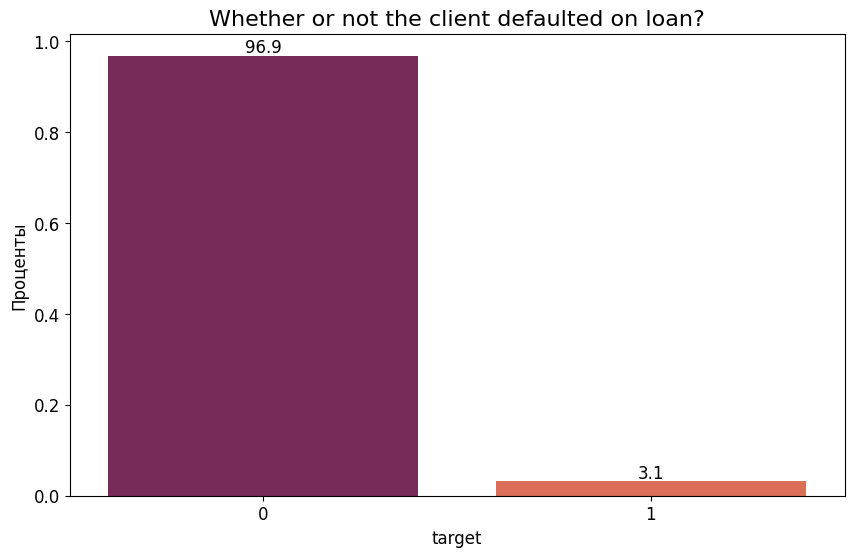

In [17]:
norm_target = (df_train["target"].value_counts(
    normalize=True).rename("percent").reset_index())

plt.figure(figsize=(10, 6))
ax = sns.barplot(x="target", y="percent", palette='rocket', data=norm_target)

for p in ax.patches:
    ax.annotate(
        format(p.get_height() * 100, '.1f'),  # текст
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 6),        
        textcoords='offset points',
        fontsize=12)

plt.title("Whether or not the client defaulted on loan?", fontsize=16)
plt.xlabel("target", fontsize=12)
plt.ylabel("Проценты", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

- И на рапределение целевой переменной в разрезе WEEK_NUM

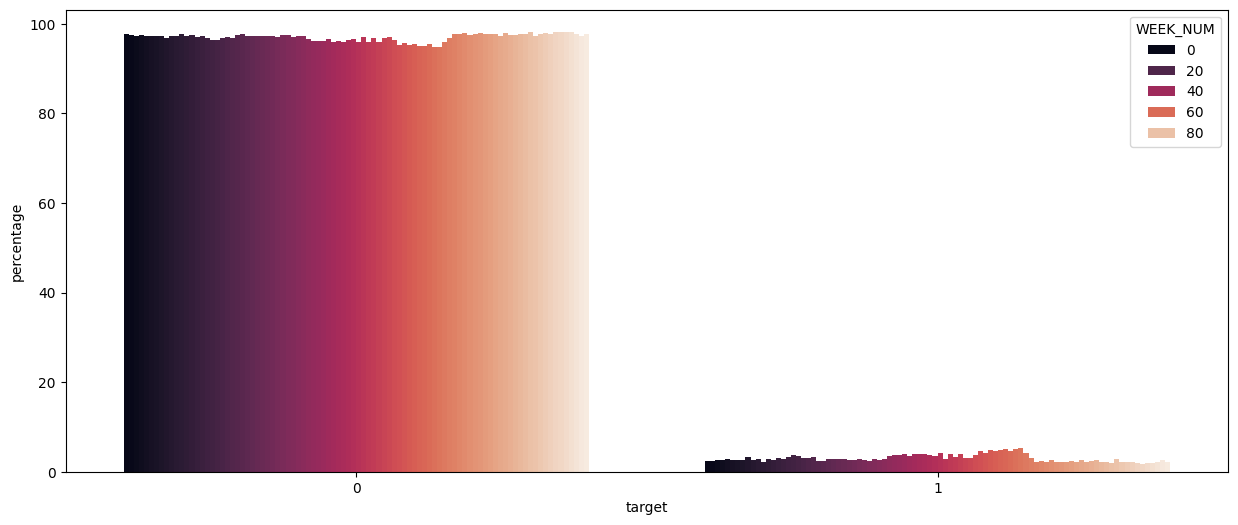

In [14]:
plt.figure(figsize=(15, 6))

data = (df_train.groupby("WEEK_NUM")["target"].value_counts(
    normalize=True).rename('percentage').mul(100).reset_index().sort_values(
        by="WEEK_NUM"))

ax = sns.barplot(x="target",
                 y="percentage",
                 hue="WEEK_NUM",
                 data=data,
                 palette='rocket')

**Выводы**
- Выборка очень сильно несбалансированная
- Каждую неделю есть небольшой процент target=1

### Age
- Посмотрим на распределение возраста в разрезе целевой переменнной

In [28]:
def displot(data: pd.DataFrame, x: str, hue: str, title: str,
            xlabel: str) -> None:

    ax = sns.displot(data=data,
                     x=x,
                     kind="kde",
                     hue=hue,
                     common_norm=False,
                     palette='rocket',
                     height=6,
                     aspect=2.1)

    sns.move_legend(ax, loc='center right', fontsize=14, title_fontsize=14)
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel('Density', fontsize=14)  
    plt.tick_params(axis='both', labelsize=12)
    plt.show()

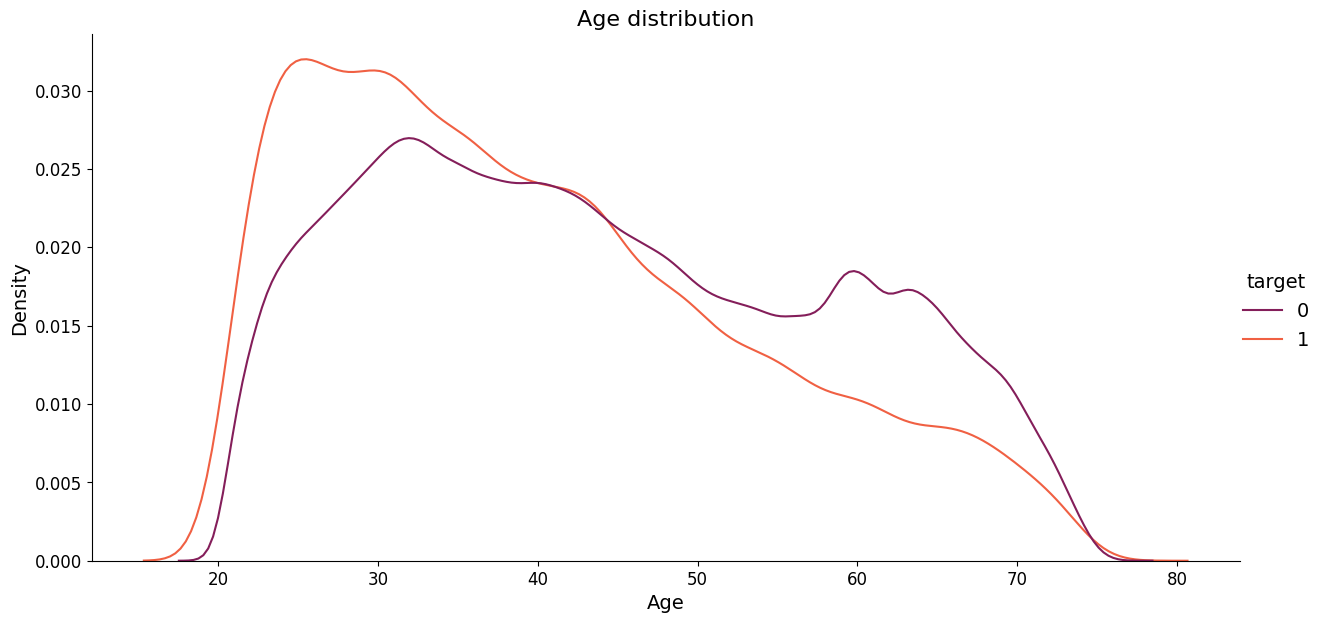

In [29]:
displot(data=df_train,
        x="birth_259D",
        hue="target",
        title='Age distribution',
        xlabel='Age')

**Выводы**
- для target=1 (дефолт) пик возраста находится на 20-30 лет, т.е. среди клиентов с дефолтом больше молодых
- для target=0 два основных пика: около 30 лет и около 60 лет

### Loan Amounts

- Расcмотрим рапределение сумм кредита (сумма кредита, ежемесячный платеж и первоначальный взнос) в разрезе целевой переменной

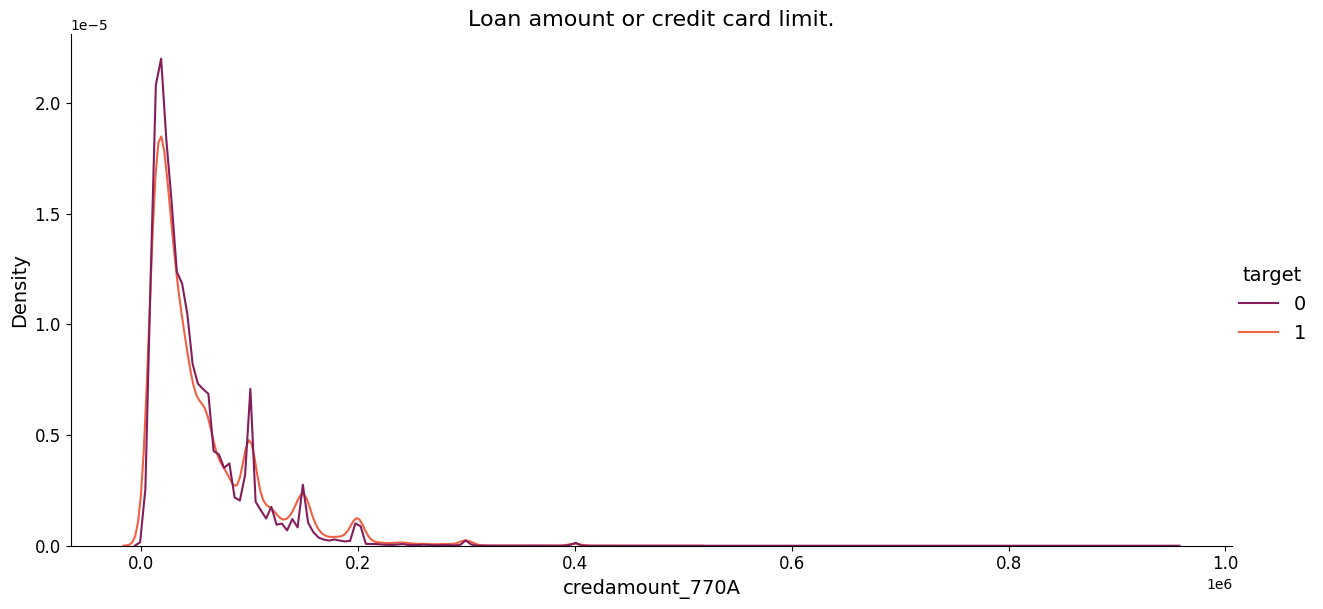

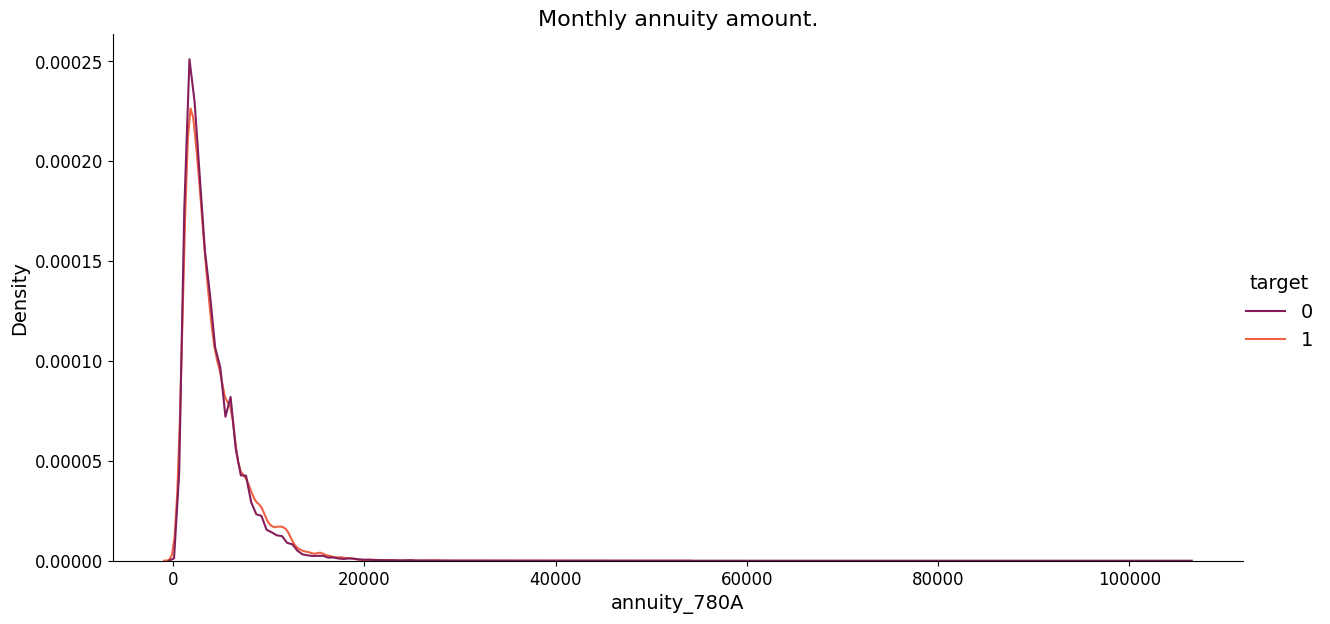

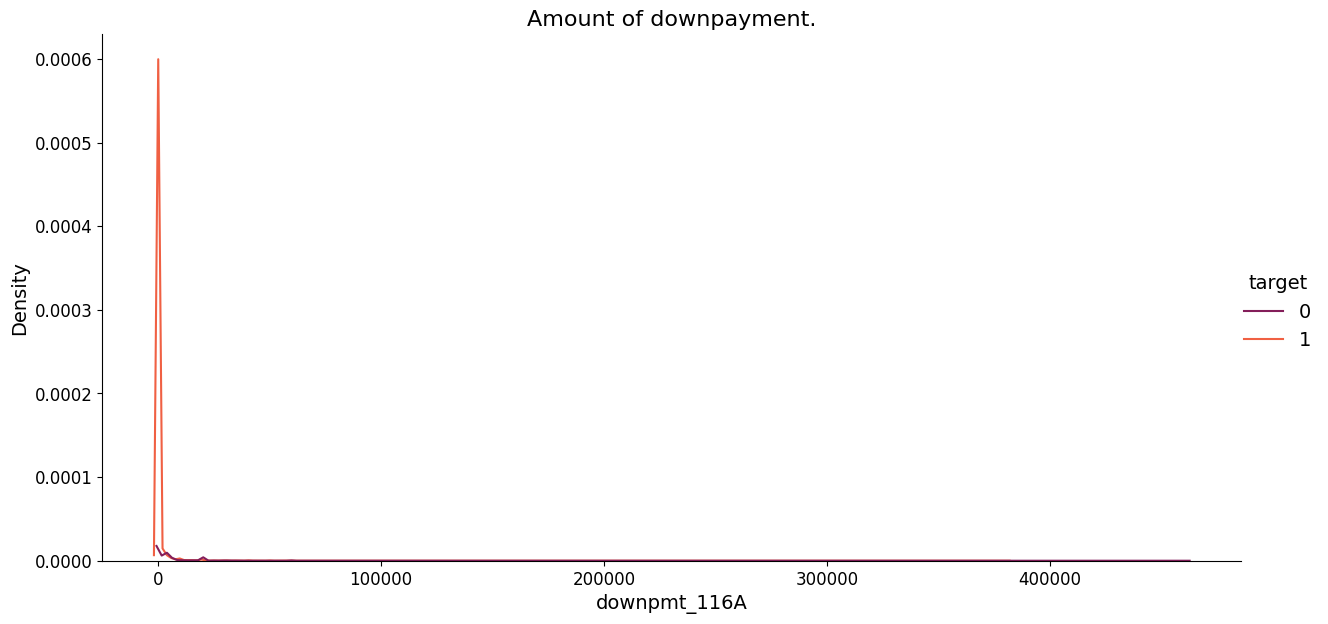

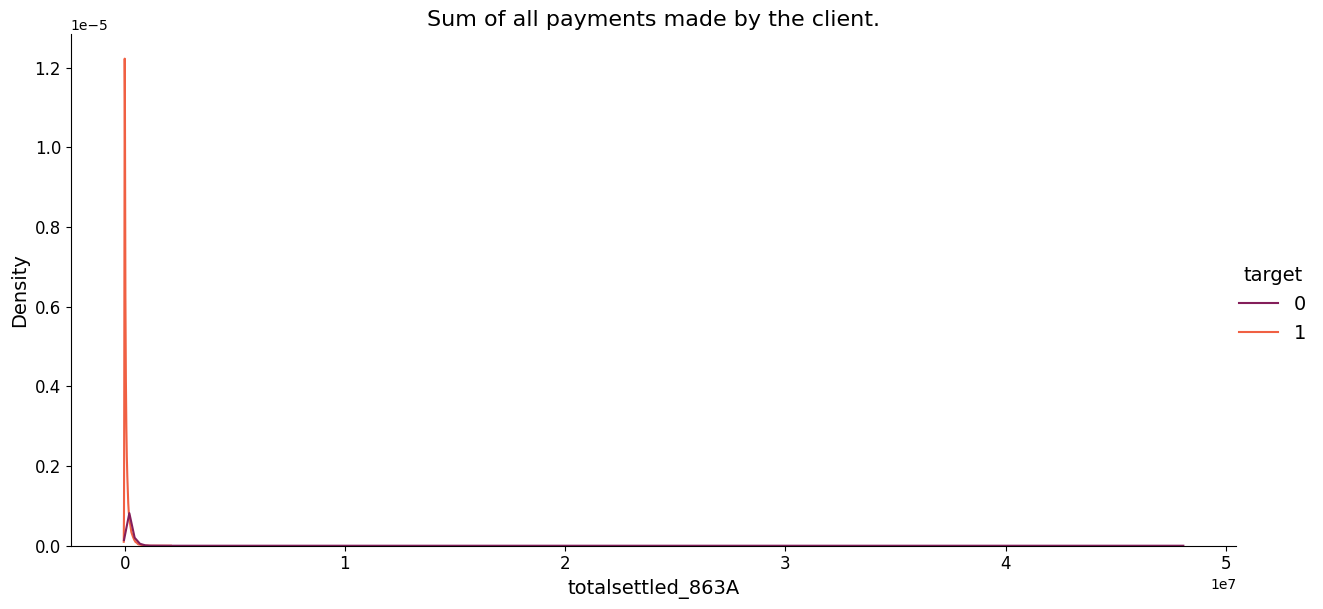

In [19]:
amount_cols = [
    "credamount_770A", "annuity_780A", "downpmt_116A", "totalsettled_863A"
]
for col in amount_cols:
    displot(data=df_train,
            x=col,
            hue="target",
            title=feature_definitions[col],
            xlabel=col)

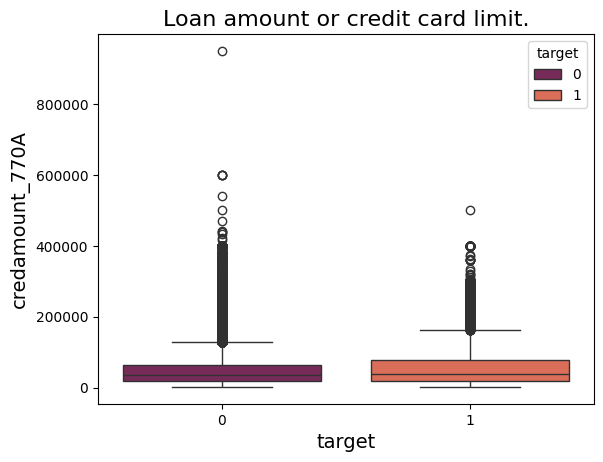

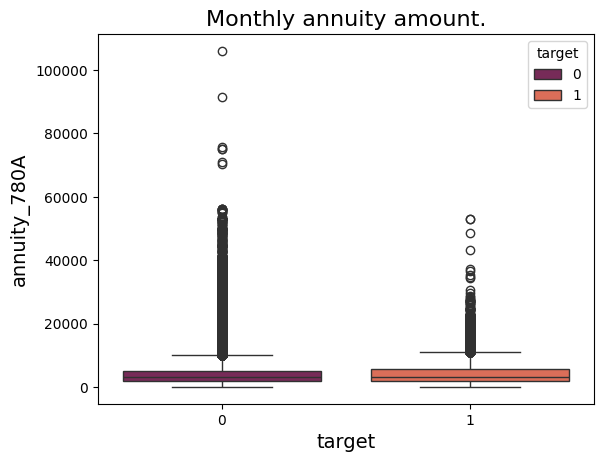

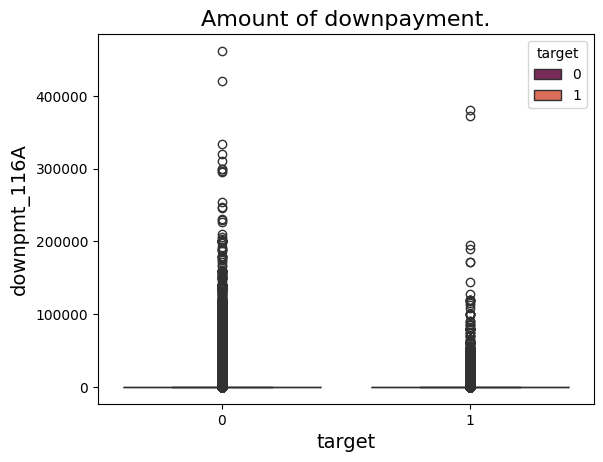

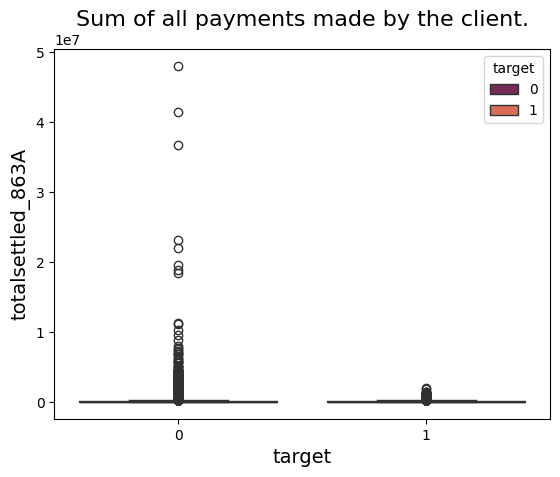

In [41]:
for col in amount_cols:
    sns.boxplot(x='target',
                y=col,
                hue='target',
                data=df_train,
                palette='rocket')

    plt.title(feature_definitions[col], fontsize=16)
    plt.xlabel('target', fontsize=14)
    plt.ylabel(col, fontsize=14)
    plt.show()

In [ ]:
# df_train[amount_cols + ["target"]].groupby("target").describe().T

**Выводы**
- распределения в разрезе target сильно не отличаются, средние значения примерно одинаковые
- у target=0 разброс значений существеннее

### Estimated probability that the client will default

In [14]:
def barplot_group(df_data: pd.DataFrame,
                  col_main: str,
                  col_group: str,
                  title: str,
                  is_horizontal: bool = True) -> None:
    """
    Building a barplot with normalized data with the output of values on the graph
    """

    plt.figure(figsize=(15, 7))
    data = (df_data.groupby(
        [col_group])[col_main].value_counts(normalize=True).rename(
            'percentage').mul(100).reset_index().sort_values(by=col_group))

    if is_horizontal:
        ax = sns.barplot(x="percentage",
                         y=col_main,
                         hue=col_group,
                         data=data,
                         palette='rocket')
        xlabel = 'Percentage'
        ylabel = col_main
    else:
        ax = sns.barplot(x=col_main,
                         y="percentage",
                         hue=col_group,
                         data=data,
                         palette='rocket')
        xlabel = col_main
        ylabel = 'Percentage'

    for container in ax.containers:
        ax.bar_label(container, fontsize=12, fmt='%.2f')

    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.tick_params(axis='both', labelsize=12)
    sns.move_legend(ax, loc='best', fontsize=14, title_fontsize=14)
    plt.show()

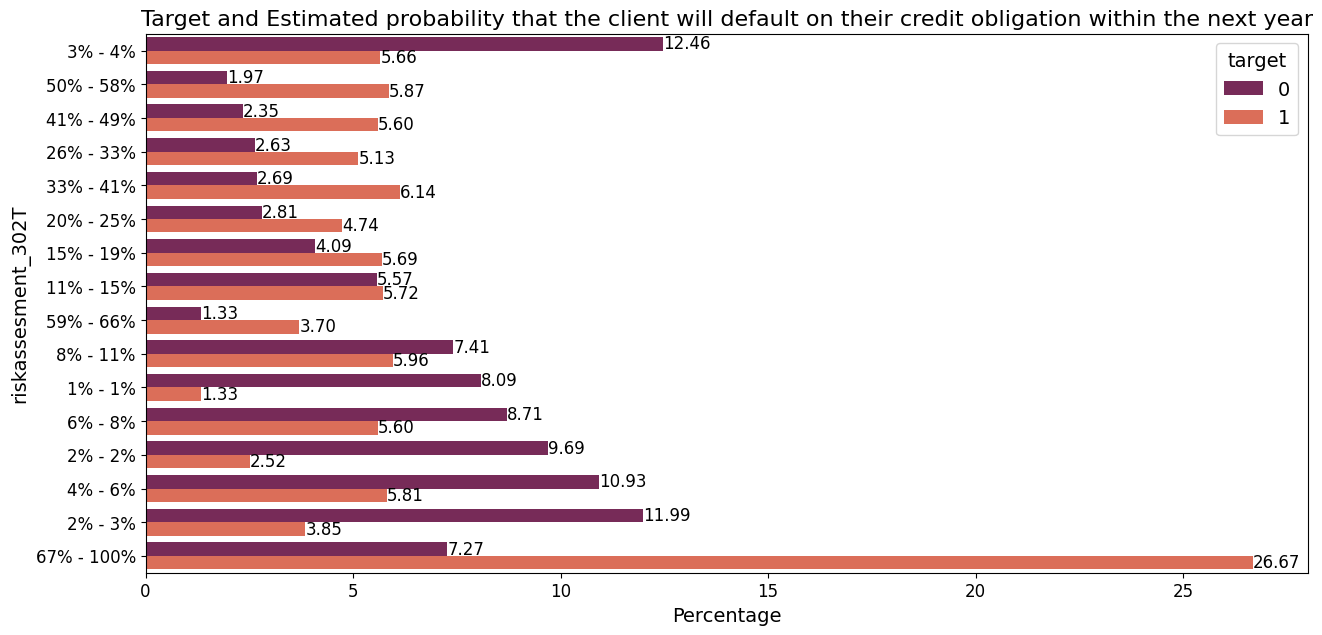

In [15]:
barplot_group(
    df_data=df_train,
    col_main="riskassesment_302T",
    col_group="target",
    title= "Target and Estimated probability that the client will default on their credit obligation within the next year"
)

**Выводы**
- Для target=1 (дефолт) большой процент клиентов с предполагаемой вероятностью дефолта от 67%
- Для target=0 ожидаемо больше клиентов с низкой предполагаемой вероятностью дефолта
- Но это поле заполнено для очень небольшого количества записей

### Gender

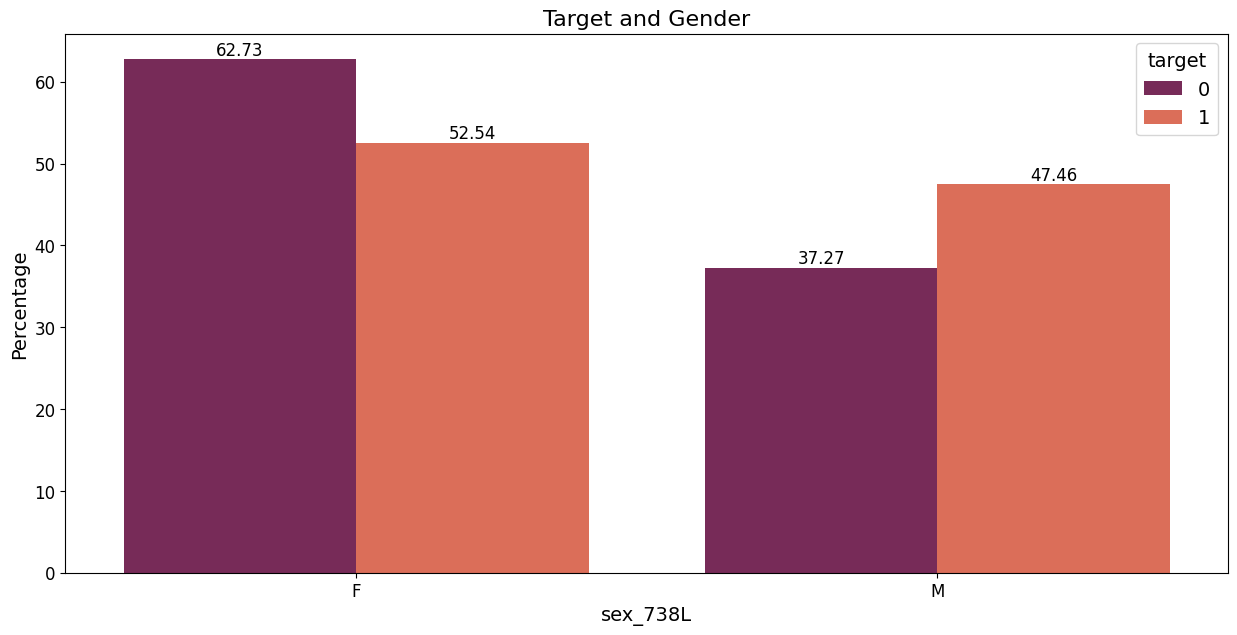

In [16]:
barplot_group(
    df_data=df_train,
    col_main="sex_738L",
    col_group="target",
    title= "Target and Gender",
    is_horizontal=False
)

**Выводы**
- Соотношение мужчин и женщин-клиентов для target=1 (дефолт) примерно одинаковое
- Для target=0 женщин больше

### Interest rate

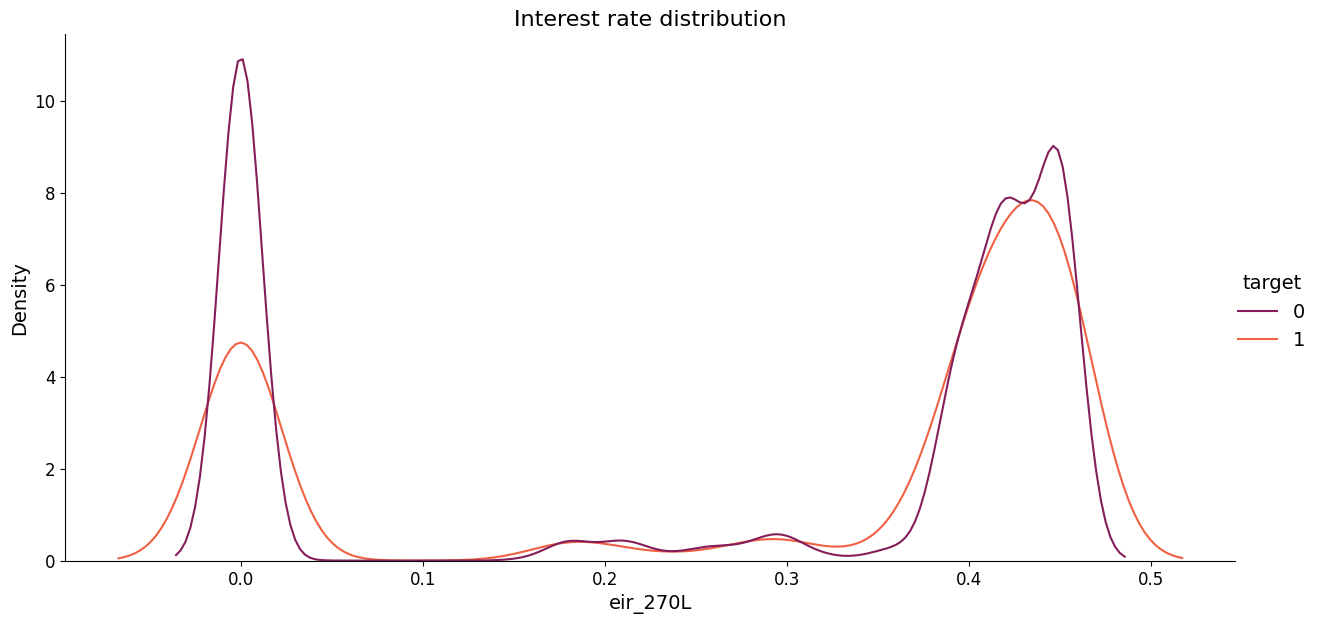

In [31]:
displot(data=df_train,
        x="eir_270L",
        hue="target",
        title='Interest rate distribution',
        xlabel='eir_270L')

**Выводы**
- Распределения процентной ставки существенно не отличаются для target 1 и 0, пики примерно одинаковые.

### Education

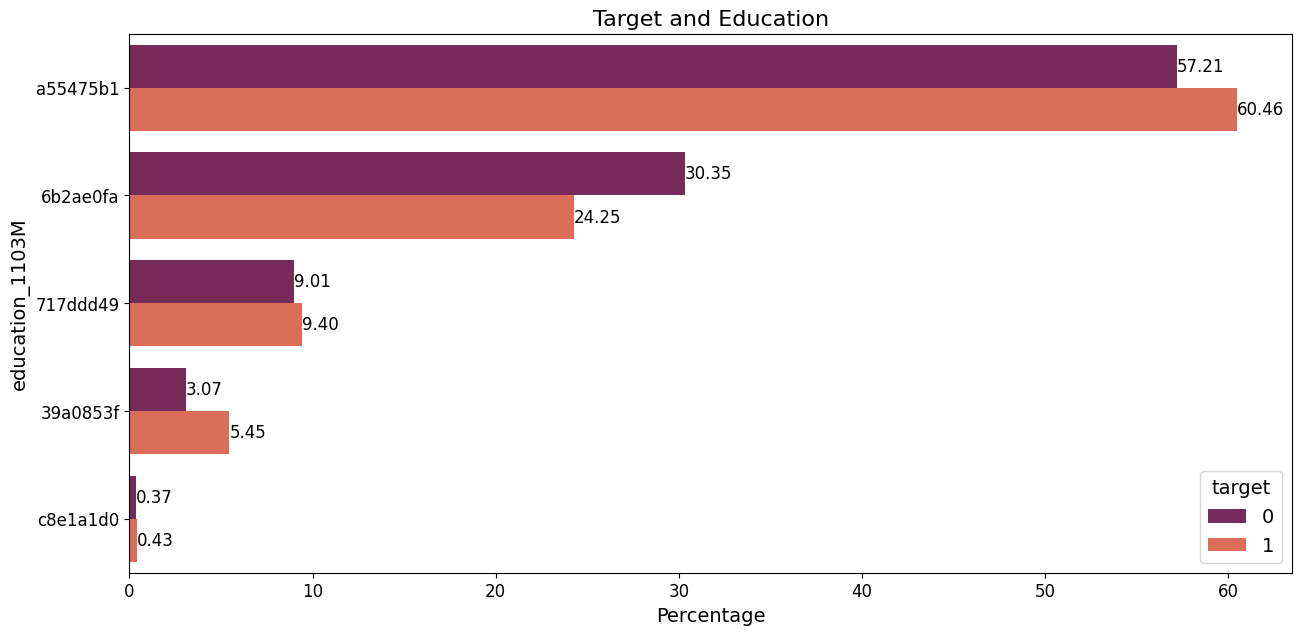

In [17]:
barplot_group(
    df_data=df_train,
    col_main="education_1103M",
    col_group="target",
    title= "Target and Education"
)

**Выводы**
- в целом соотношение клиентов в разрезе уровня образования и целевой переменной примерно одинаковое: и для target=1, и для target=0 больше всего клиентов с образованием a55475b1, и меньше всего c8e1a1d0.
- есть небольшие отличия именно в процентном соотношении, например, для target=0 процентное соотношение клиентов с образованием a55475b1 чуть ниже = 57, чем для target=1 (60), также разница заметна для образования c8e1a1d0 и 39a0853f.

### Family state

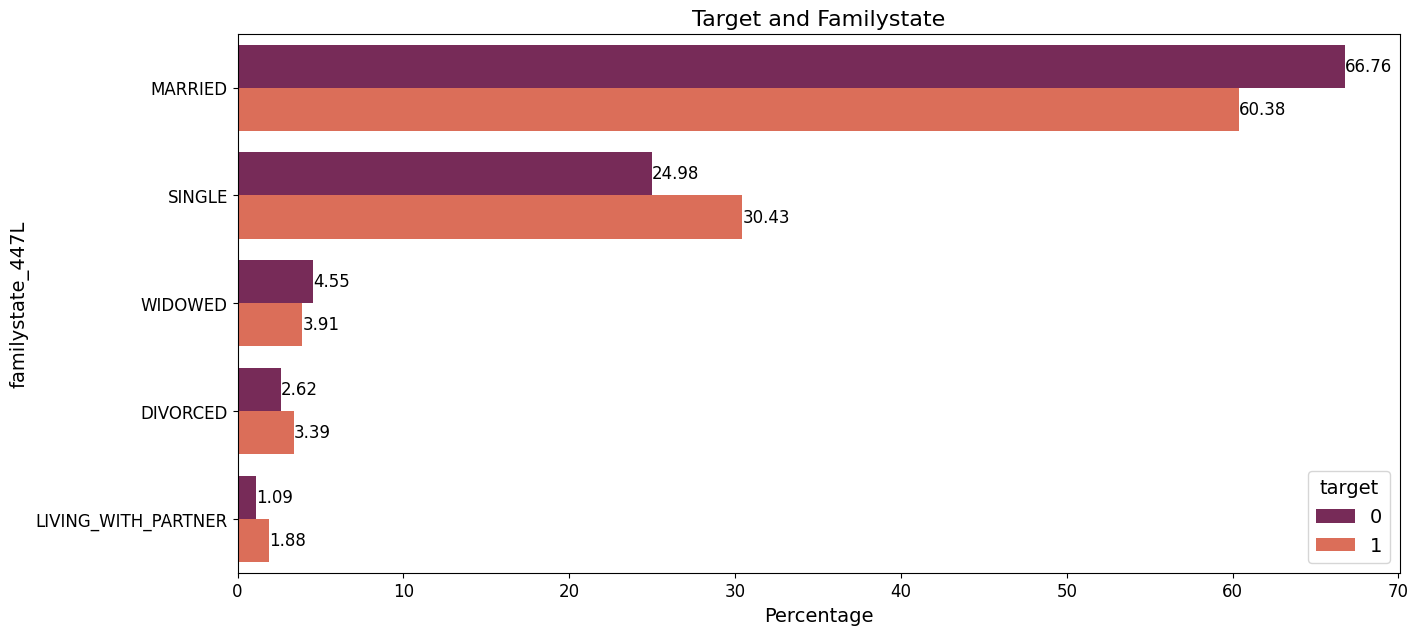

In [18]:
barplot_group(
    df_data=df_train,
    col_main="familystate_447L",
    col_group="target",
    title= "Target and Familystate"
)

**Выводы**
- в целом соотношение клиентов в разрезе уровня семейного статуса и целевой переменной примерно одинаковое: и для target=1, и для target=0 больше всего клиентов в статусе Married, и меньше всего LivingWithPartner
- есть небольшие отличия в соотношение клиентов в статусе Married и Single: для target=1(дефолт) клиентов в статусе Married больше в 2 раза, чем Singled,  для target=0 - почти в 3 раза.

# Feature tranformation, selection and engineering 

- Фильтрация и трансформация фич частично была выполнена выше, еще на этапе предобработки данных
- Здесь заполним пропуски, отфильтруем фичи и создадим новые
- Выборка очень не сбалансированная, признаки в которых пропусков больше 80% на все датасетеи и 90% при target=1 были отфильтрованы еще на этапе предобработки.

## Dates

### Age

In [16]:
age_columns = [col for col in df_train.columns if "birth" in col]

print("-------Train-------")
for col in age_columns:
    is_null = np.mean(df_train[col].isnull())
    print('{} - {}%'.format(col, round(is_null*100)))
    
print("-------Test-------")
for col in age_columns:
    is_null = np.mean(df_test[col].isnull())
    print('{} - {}%'.format(col, round(is_null*100)))

-------Train-------
birthdate_574D - 60%
dateofbirth_337D - 9%
birth_259D - 0%
-------Test-------
birthdate_574D - 100%
dateofbirth_337D - 0%
birth_259D - 40%


In [13]:
df_train[age_columns].describe()

,birthdate_574D,dateofbirth_337D,birth_259D
count,607871.0000,1385691.0000,1526659.0000
mean,43.5227,44.1111,44.0956
std,13.9994,13.8500,14.0401
min,20.0000,0.0000,20.0000
25%,32.0000,32.0000,32.0000
50%,42.0000,42.0000,42.0000
75%,55.0000,55.0000,56.0000
max,76.0000,120.0000,76.0000


In [14]:
df_test[age_columns].describe()

,birthdate_574D,dateofbirth_337D,birth_259D
count,0.0000,10.0000,6.0000
mean,NaN,50.1000,55.1667
std,NaN,15.0070,13.8046
min,NaN,28.0000,38.0000
25%,NaN,38.5000,43.5000
50%,NaN,49.0000,58.0000
75%,NaN,62.7500,64.2500
max,NaN,72.0000,72.0000


- Проверим, совпадают ли значения возраста

In [42]:
not_matching_ages = df_train[age_columns][df_train[age_columns]["birth_259D"] != df_train[age_columns]["dateofbirth_337D"]]
print(not_matching_ages.shape)
not_matching_ages[:10]

(1061, 3)


,birthdate_574D,dateofbirth_337D,birth_259D
1738,60,74,60
2554,33,34,33
3313,<NA>,105,65
4545,<NA>,61,56
5175,<NA>,6,31
6673,35,104,35
9317,45,46,45
10947,31,38,31
11034,<NA>,68,71
13024,<NA>,1,23


- birth_259D в тренировочном датасете без пропусков, в тестовом есть пропуски
- dateofbirth_337D в тренировочном датасете с пропусками и есть выбросы (есть ошибки в данных), в тестовом заполнена
- из всего количества около 1000 записей в столбцах birth_259D и dateofbirth_337D отличаются


 - Поэтому в качестве возраста возьмем birth_259D, если не заполнено - dateofbirth_337D, объединим в один столбец, все остальные даты рождения удалим

In [17]:
def get_bins_age(data) -> str:
    """
    Generate bins for age
    """
    if isinstance(data, (int, float)):
        if data <= 35:
            return 'Young'
        elif 35 < data <= 55:
            return 'Middle-aged'
        elif data > 55:
            return 'Older'
    return "Unknown"


def handle_age_columns(df: pd.DataFrame, columns_to_drop: list[str]):
    df["age"] = df.apply(lambda x: x["dateofbirth_337D"]
                         if pd.isnull(x['birth_259D']) else x['birth_259D'],
                         axis=1).astype('Int64')
    df["age_bins"] = df["age"].transform(lambda x: get_bins_age(x))
    df = df.drop(columns_to_drop, axis=1)
    return df

df_train = handle_age_columns(df_train, age_columns)
df_test = handle_age_columns(df_test, age_columns)
df_test[["age", "age_bins"]][:5]

,age,age_bins
0,40,Middle-aged
1,28,Young
2,35,Young
3,63,Older
4,44,Middle-aged


### Other dates

In [18]:
date_columns = [col for col in df_train.columns if col[-1] == "D"]
for col in date_columns:
    is_null = np.mean(df_train[col].isnull()) 
    if is_null > 0:
        print('{} - {}%'.format(col, round(is_null*100)))
len(date_columns)

datefirstoffer_1144D - 55%
datelastinstal40dpd_247D - 91%
datelastunpaid_3546854D - 58%
dtlastpmtallstes_4499206D - 64%
firstclxcampaign_1125D - 56%
firstdatedue_489D - 32%
lastactivateddate_801D - 30%
lastapplicationdate_877D - 20%
lastapprdate_640D - 29%
lastdelinqdate_224D - 64%
lastrejectdate_50D - 50%
maxdpdinstldate_3546855D - 54%
validfrom_1069D - 90%
assignmentdate_4527235D - 92%
responsedate_1012D - 53%
responsedate_4527233D - 57%
responsedate_4917613D - 85%
max_approvaldate_319D - 29%
max_creationdate_885D - 20%
max_dateactivated_425D - 30%
max_dtlastpmt_581D - 46%
max_dtlastpmtallstes_3545839D - 36%
max_employedfrom_700D - 37%
max_firstnonzeroinstldate_307D - 22%
max_recorddate_4527225D - 70%
max_deductiondate_4917603D - 90%
max_processingdate_168D - 68%
max_dateofcredend_289D - 17%
max_dateofcredend_353D - 34%
max_dateofcredstart_181D - 34%
max_dateofcredstart_739D - 17%
max_dateofrealrepmt_138D - 34%
max_lastupdate_1112D - 17%
max_lastupdate_388D - 34%
max_numberofoverduei

42

In [18]:
df_train[date_columns].describe()

,datefirstoffer_1144D,datelastinstal40dpd_247D,datelastunpaid_3546854D,dtlastpmtallstes_4499206D,firstclxcampaign_1125D,firstdatedue_489D,lastactivateddate_801D,lastapplicationdate_877D,lastapprdate_640D,lastdelinqdate_224D,lastrejectdate_50D,maxdpdinstldate_3546855D,validfrom_1069D,assignmentdate_4527235D,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,max_approvaldate_319D,max_creationdate_885D,max_dateactivated_425D,max_dtlastpmt_581D,max_dtlastpmtallstes_3545839D,max_employedfrom_700D,max_firstnonzeroinstldate_307D,max_recorddate_4527225D,max_deductiondate_4917603D,max_processingdate_168D,max_dateofcredend_289D,max_dateofcredend_353D,max_dateofcredstart_181D,max_dateofcredstart_739D,max_dateofrealrepmt_138D,max_lastupdate_1112D,max_lastupdate_388D,max_numberofoverdueinstlmaxdat_148D,max_numberofoverdueinstlmaxdat_641D,max_overdueamountmax2date_1002D,max_overdueamountmax2date_1142D,max_refreshdate_3813885D,last_openingdate_313D,max_openingdate_857D,empl_employedfrom_271D
count,692924.0000,133818.0000,639000.0000,549540.0000,667445.0000,1044556.0000,1073072.0000,1221522.0000,1084618.0000,548684.0000,757613.0000,700659.0000,151773.0000,114978.0000,720000.0000,660327.0000,224912.0000,1083660.0000,1221522.0000,1071981.0000,822819.0000,977672.0000,967490.0000,1191786.0000,457934.0000,150732.0000,482265.0000,1264006.0000,1014069.0000,1014069.0000,1264006.0000,1013698.0000,1264006.0000,1014068.0000,724308.0000,514298.0000,720006.0000,519065.0000,1385691.0000,105111.0000,105087.0000,566701.0000
mean,2459.7090,1964.5644,958.4602,413.0210,989.7513,1837.2537,630.5002,468.9857,609.9642,538.5099,834.9679,1006.5930,17.7369,-13.9452,-13.7492,-13.9553,-13.5803,609.4609,468.9857,629.9727,314.5771,152.6750,3345.6540,496.3487,-13.9515,4.2539,7.7942,-794.1148,182.3764,844.2225,447.8898,419.0834,-4.5010,386.3208,1130.3684,492.7020,1184.9538,527.7076,-13.8944,1553.2299,1541.1673,2208.6830
std,1617.8003,1554.0334,1245.6590,842.6074,465.5540,1452.5593,907.7938,748.0970,891.2190,646.6790,1004.8216,1209.8455,29.2670,0.4105,1.4330,0.3812,1.8151,890.6709,748.0970,907.2419,322.3499,284.6363,2634.6361,801.2719,0.4006,14.3090,28.8353,896.1925,1235.3155,922.0883,642.9566,697.4616,6.3411,648.3334,1115.3195,595.4493,1072.2074,634.7515,0.5797,450.3542,448.6789,2275.9910
min,-13.0000,26.0000,-13.0000,-13.0000,-14.0000,-47.0000,-14.0000,-14.0000,-14.0000,-13.0000,-14.0000,-13.0000,-14.0000,-14.0000,-14.0000,-14.0000,-14.0000,-14.0000,-14.0000,-14.0000,-14.0000,-14.0000,-12.0000,-47.0000,-14.0000,-13.0000,-14.0000,-28697.0000,-28796.0000,-14.0000,-316.0000,-28658.0000,-14.0000,-14.0000,-13.0000,-14.0000,-13.0000,-14.0000,-14.0000,524.0000,524.0000,-13.0000
25%,977.0000,706.0000,100.0000,1.0000,717.0000,569.0000,145.0000,78.0000,139.0000,72.0000,140.0000,162.0000,-6.0000,-14.0000,-14.0000,-14.0000,-14.0000,139.0000,78.0000,144.0000,75.0000,-4.0000,1512.0000,62.0000,-14.0000,-6.0000,-10.0000,-899.0000,-50.0000,313.0000,88.0000,65.0000,-8.0000,56.0000,329.0000,61.0000,380.0000,75.0000,-14.0000,1204.0000,1195.0000,643.0000
50%,1982.0000,1461.0000,425.0000,42.0000,1116.0000,1525.0000,306.0000,217.0000,297.0000,297.0000,436.0000,495.0000,9.0000,-14.0000,-14.0000,-14.0000,-14.0000,297.0000,217.0000,306.0000,210.0000,12.0000,2609.0000,217.0000,-14.0000,2.0000,1.0000,-603.0000,100.0000,518.0000,202.0000,185.0000,-5.0000,172.0000,709.0000,217.0000,828.0000,244.0000,-14.0000,1560.0000,1539.0000,1432.0000
75%,4225.0000,3447.0000,1292.0000,385.0000,1338.0000,2786.0000,647.0000,495.0000,626.0000,800.0000,1171.0000,1407.0000,34.0000,-14.0000,-14.0000,-14.0000,-14.0000,625.0000,495.0000,646.0000,450.0000,181.0000,4457.0000,533.0000,-14.0000,11.0000,12.0000,-364.0000,357.0000,937.0000,460.0000,432.0000,-1.0000,400.0000,1562.0000,740.0000,1640.0000,783.0000,-14.0000,1901.0000,1887.0000,2985.0000
max,4907.0000,5227.0000,5305.0000,5253.0000,1709.0000,5360.0000,5352.0000,5354.0000,5354.0000,4930.0000,5335.0000,5271.0000,134.0000,-7.0000,7.0000,-3.0000,8.0000,5354.000

- Незаполенные даты, а точнее количество дней, заполним 0

In [19]:
for column in date_columns:
    if np.mean(df_train[column].isnull()) > 0:        
        df_train[column].fillna(0, inplace=True)

    if np.mean(df_test[column].isnull()) > 0:       
        df_test[column].fillna(0, inplace=True)
        
df_train[date_columns].isna().sum()[df_train[date_columns].isna().sum() > 0]

Series([], dtype: int64)

## Category

- Посмотрим на категориальные признаки, у которых много уникальных значений

In [20]:
cat_columns = df_train.select_dtypes("object").columns.to_list()

In [21]:
for col in cat_columns:
    cnts = df_train[col].value_counts(dropna=False, normalize=True)
    nunique = df_train[col].nunique()        
    if nunique > 20:
        print('{0}: {1}'.format(col, nunique))
        print(cnts)
        print()

lastapprcommoditycat_1041M: 45
lastapprcommoditycat_1041M
a55475b1       0.5582
P159_130_59    0.1680
P12_6_178      0.1022
P148_110_5     0.0415
P109_133_183   0.0369
P53_45_92      0.0205
P52_56_90      0.0145
P33_29_177     0.0137
P100_96_175    0.0118
P21_79_33      0.0115
P128_43_169    0.0065
P184_3_97      0.0043
P187_118_47    0.0018
P65_94_74      0.0016
P201_79_148    0.0016
P105_126_172   0.0013
P216_109_183   0.0010
P121_6_80      0.0006
P177_46_174    0.0006
P160_128_10    0.0004
P48_73_87      0.0004
P21_123_87     0.0003
P110_120_162   0.0002
P143_21_170    0.0001
P137_157_60    0.0001
P156_122_160   0.0001
P75_42_174     0.0001
P193_109_73    0.0001
P156_50_173    0.0001
P76_145_175    0.0000
P98_19_172     0.0000
P175_82_175    0.0000
P141_125_135   0.0000
P137_6_96      0.0000
P181_140_94    0.0000
P49_162_170    0.0000
P3_103_80      0.0000
P38_69_128     0.0000
P117_143_46    0.0000
P126_161_96    0.0000
P201_108_190   0.0000
P187_21_169    0.0000
P58_25_91      0.0

empl_industry_691L: 24
empl_industry_691L
None                0.6579
OTHER               0.2534
GOVERNMENT          0.0232
EDUCATION           0.0199
TRADE               0.0136
HEALTH              0.0085
MANUFACTURING       0.0059
AGRICULTURE         0.0035
TRANSPORTATION      0.0028
REAL_ESTATE         0.0024
MINING              0.0023
CATERING            0.0023
FINANCE             0.0021
POST_TELCO          0.0004
LAWYER              0.0004
TOURISM             0.0003
WELNESS             0.0003
IT                  0.0002
ART_MEDIA           0.0002
MARKETING           0.0002
INSURANCE           0.0001
GAMING              0.0001
RECRUITMENT         0.0001
CHARITY_RELIGIOUS   0.0000
ARMY_POLICE         0.0000
Name: proportion, dtype: float64



In [21]:
to_reduce = {
    "lastapprcommoditycat_1041M": 0.001,
    "lastcancelreason_561M": 0.001,
    "lastrejectcommoditycat_161M": 0.001,
#     "lastrejectcommodtypec_5251769M": 0.0002,
    "mode_cancelreason_3545846M": 0.001,
    "mode_classificationofcontr_400M": 0.0001,
    "mode_contractst_964M": 0.0002,
    "mode_financialinstitution_382M": 0.001,
    "mode_financialinstitution_591M": 0.0001,
#     "mode_contracttype_653M": 0.0001,
#     "mode_credor_3940957M": 0.0001,
}

In [22]:
def replace_rare_values(df: pd.DataFrame, column: str, threshold: float):
    nunique = df[column].nunique()
    rare_values = df[column].value_counts(
        dropna=False, normalize=True)[df[column].value_counts(
            dropna=False, normalize=True) < threshold].index
    df[column] = df[column].apply(lambda x: "Other" if x in rare_values else x)
    print(f"{column} reduced nunique from {nunique} to {df[column].nunique()}")
    return df, df[column].unique()


for column, threshold in to_reduce.items():
    df_train, unique_values = replace_rare_values(df_train, column, threshold)
    df_test[column] = df_test[column].apply(lambda x: "Other"
                                            if x not in unique_values else x)

lastapprcommoditycat_1041M reduced nunique from 45 to 18
lastcancelreason_561M reduced nunique from 74 to 19
lastrejectcommoditycat_161M reduced nunique from 45 to 14
mode_cancelreason_3545846M reduced nunique from 65 to 12
mode_classificationofcontr_400M reduced nunique from 101 to 11
mode_contractst_964M reduced nunique from 27 to 3
mode_financialinstitution_382M reduced nunique from 175 to 17
mode_financialinstitution_591M reduced nunique from 38 to 3


- Посмотрим на пропуски в категориальных признаках

In [24]:
for col in cat_columns:
    is_null = np.mean(df_train[col].isnull())
    nunique = df_train[col].nunique()
    if is_null > 0.5:
        print('{} - {}%, unique_values - {}'.format(col, round(is_null * 100),
                                                    nunique))
        print(df_train[col].value_counts(dropna=False, normalize=True))
        print()

cardtype_51L - 87%, unique_values - 2
cardtype_51L
None           0.8744
INSTANT        0.1240
PERSONALIZED   0.0015
Name: proportion, dtype: float64

equalitydataagreement_891L - 95%, unique_values - 2
equalitydataagreement_891L
None    0.9489
true    0.0479
false   0.0033
Name: proportion, dtype: float64

requesttype_4525192L - 56%, unique_values - 3
requesttype_4525192L
None          0.5590
DEDUCTION_6   0.3605
PENSION_6     0.0767
SOCIAL_6      0.0038
Name: proportion, dtype: float64

riskassesment_302T - 96%, unique_values - 16
riskassesment_302T
None         0.9649
3% - 4%      0.0042
2% - 3%      0.0040
4% - 6%      0.0037
2% - 2%      0.0032
6% - 8%      0.0030
67% - 100%   0.0030
1% - 1%      0.0027
8% - 11%     0.0026
11% - 15%    0.0020
15% - 19%    0.0015
20% - 25%    0.0010
33% - 41%    0.0010
26% - 33%    0.0010
41% - 49%    0.0009
50% - 58%    0.0008
59% - 66%    0.0005
Name: proportion, dtype: float64

mode_periodicityofpmts_1102L - 75%, unique_values - 4
mode_periodici

In [23]:
for column in cat_columns:
    df_train[column].fillna("Unknown", inplace=True)
    df_test[column].fillna("Unknown", inplace=True)

df_train[cat_columns].isna().sum()[df_train[cat_columns].isna().sum() > 0]

Series([], dtype: int64)

## Numeric values

In [24]:
numeric_columns = [
    col for col in df_train.select_dtypes(
        exclude=["object", "bool", "category"]).columns
    if col[-1] != "D" and col not in ["target", "case_id"]
]

for col in numeric_columns:
    is_null = np.mean(df_train[col].isnull())
    nunique = df_train[col].nunique()
    if is_null > 0:
        print('{} - {}%, unique_values - {}'.format(col, round(is_null * 100),
                                                    nunique))
len(numeric_columns)

actualdpdtolerance_344P - 27%, unique_values - 170
amtinstpaidbefduel24m_4187115A - 37%, unique_values - 610152
annuitynextmonth_57A - 0%, unique_values - 66202
avgdbddpdlast24m_3658932P - 40%, unique_values - 4524
avgdbddpdlast3m_4187120P - 62%, unique_values - 3939
avgdbdtollast24m_4525197P - 64%, unique_values - 4031
avgdpdtolclosure24_3658938P - 31%, unique_values - 4313
avginstallast24m_3658937A - 41%, unique_values - 92853
avglnamtstart24m_4525187A - 89%, unique_values - 57039
avgmaxdpdlast9m_3716943P - 50%, unique_values - 223
avgoutstandbalancel6m_4187114A - 55%, unique_values - 559675
avgpmtlast12m_4525200A - 67%, unique_values - 92820
cntincpaycont9m_3716944L - 30%, unique_values - 105
cntpmts24_3658933L - 30%, unique_values - 26
currdebt_22A - 0%, unique_values - 363802
currdebtcredtyperange_828A - 0%, unique_values - 235536
daysoverduetolerancedd_3976961L - 30%, unique_values - 4941
eir_270L - 13%, unique_values - 115
inittransactionamount_650A - 87%, unique_values - 46692


mean_residualamount_856A - 40%, unique_values - 497732
mean_totalamount_6A - 36%, unique_values - 740969
mean_totalamount_996A - 42%, unique_values - 413355
mean_totaldebtoverduevalue_178A - 17%, unique_values - 51440
mean_totaldebtoverduevalue_718A - 19%, unique_values - 959
mean_totaloutstanddebtvalue_39A - 17%, unique_values - 1053820
mean_totaloutstanddebtvalue_668A - 19%, unique_values - 704
last_amount_416A - 93%, unique_values - 35053
max_amount_416A - 93%, unique_values - 37816
mean_pmts_dpd_1073P - 17%, unique_values - 2628
mean_pmts_dpd_303P - 34%, unique_values - 3018
mean_pmts_overdue_1140A - 17%, unique_values - 399559
mean_pmts_overdue_1152A - 34%, unique_values - 630221
max_pmts_year_1139T - 17%, unique_values - 3
max_pmts_year_507T - 34%, unique_values - 19


217

In [27]:
df_train[numeric_columns].describe()

,WEEK_NUM,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_157L,clientscnt_304L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,credamount_770A,currdebt_22A,currdebtcredtyperange_828A,daysoverduetolerancedd_3976961L,disbursedcredamount_1113A,downpmt_116A,eir_270L,homephncnt_628L,inittransactionamount_650A,interestrate_311L,lastapprcredamount_781A,lastrejectcredamount_222A,maininc_215A,maxannuity_159A,maxannuity_4075009A,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,maxdebt4_972A,maxdpdfrom6mto36m_3546853P,maxdpdinstlnum_3546846P,maxdpdlast12m_727P,maxdpdlast24m_143P,maxdpdlast3m_392P,maxdpdlast6m_474P,maxdpdlast9m_1059P,maxdpdtolerance_374P,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,mindbddpdlast24m_3658935P,mindbdtollast24m_4525191P,mobilephncnt_593L,monthsannuity_845L,numactivecreds_622L,numactivecredschannel_414L,numactiverelcontr_750L,numcontrs3months_479L,numincomingpmts_3546848L,numinstlallpaidearly3d_817L,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,contractssum_5085716L,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,firstquarter_103L,fourthquarter_440L,numberofqueries_373L,pmtaverage_4527227A,pmtcount_4527229L,pmtcount_693L,pmtscount_423L,pmtssum_45A,riskassesment_940T,secondquarter_766L,thirdquarter_1082L,mean_actualdpd_943P,mean_annuity_853A,mean_byoccupationinc_3656910L,mean_childnum_21L,mean_credacc_actualbalance_314A,mean_credacc_credlmt_575A,mean_credacc_maxhisbal_375A,mean_credacc_minhisbal_90A,mean_credacc_transactions_402L,mean_credamount_590A,mean_currdebt_94A,mean_downpmt_134A,mean_mainoccupationinc_437A,mean_maxdpdtolerance_577P,mean_outstandingdebt_522A,mean_pmtnum_8L,mean_revolvingaccount_394A,mean_tenor_203L,mean_amount_4527230A,mean_amount_4917619A,mean_pmtamount_36A,mean_annualeffectiverate_199L,mean_annualeffectiverate_63L,mean_contractsum_5085717L,mean_credlmt_230A,mean_credlmt_935A,mean_debtoutstand_525A,mean_debtoverdue_47A,mean_dpdmax_139P,mean_dpdmax_757P,max_dpdmaxdatemonth_442T,max_dpdmaxdatemonth_89T,max_dpdmaxdateyear_596T,max_dpdmaxdateyear_896T,mean_instlamount_768A,mean_instlamount_852A,mean_monthlyinstlamount_332A,mean_monthlyinstlamount_674A,mean_nominalrate_281L,mean_nominalrate_498L,mean_numberofcontrsvalue_258L,mean_numberofcontrsvalue_358L,mean_numberofinstls_229L,mean_numberofinstls_320L,mean_numberofoutstandinstls_520L,mean_numb

- Пропущенные числовые значения заполним 0

In [25]:
for column in numeric_columns:
    if np.mean(df_train[column].isnull()) > 0:
        df_train[column].fillna(0, inplace=True)

    if column != "target" and np.mean(df_test[column].isnull()) > 0:
        df_test[column].fillna(0, inplace=True)

df_train.isna().sum()[df_train.isna().sum() > 0]

Series([], dtype: int64)

## Correlation matrix

In [26]:
df_train.shape

(1526659, 321)

- Построим матрицу корреляций для числовых признаков и удалим сильно скоррелированные между собой признаки

In [25]:
cor_matrix = df_train.drop(["target", "case_id", "WEEK_NUM"],
                           axis=1).corr(method='spearman',
                                        numeric_only=True).abs()

cor_matrix = cor_matrix.where(
    np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))

In [31]:
to_drop = [
    column for column in cor_matrix.columns if any(cor_matrix[column] > 0.9)
]
print(len(to_drop))
to_drop

76


['currdebt_22A',
 'disbursedcredamount_1113A',
 'interestrate_311L',
 'lastapprdate_640D',
 'maxdpdlast9m_1059P',
 'maxdpdtolerance_374P',
 'maxinstallast24m_3658928A',
 'maxlnamtstart6m_4525199A',
 'maxoutstandbalancel12m_4187113A',
 'numincomingpmts_3546848L',
 'numinstlallpaidearly3d_817L',
 'numinstls_657L',
 'numinstlsallpaid_934L',
 'numinstlswithoutdpd_562L',
 'numinstpaid_4499208L',
 'numinstpaidearly3d_3546850L',
 'numinstpaidearly3dest_4493216L',
 'numinstpaidearly5dobd_4499205L',
 'numinstpaidearly_338L',
 'numinstpaidearlyest_4493214L',
 'numinstpaidlate1d_3546852L',
 'numinstregularpaid_973L',
 'numinstregularpaidest_4493210L',
 'numinsttopaygr_769L',
 'numinstunpaidmax_3546851L',
 'numinstunpaidmaxest_4493212L',
 'pctinstlsallpaidlate1d_3546856L',
 'pctinstlsallpaidlate4d_3546849L',
 'pctinstlsallpaidlate6d_3546844L',
 'sellerplacescnt_216L',
 'sumoutstandtotal_3546847A',
 'sumoutstandtotalest_4493215A',
 'totaldebt_9A',
 'totalsettled_863A',
 'totinstallast1m_4525188A',


In [27]:
# Сохраним признаки при пороге = 0.9 в перемеенную,
# т.к. построение корреляционной матрицы очень длительное для такого количества признаков
to_drop = [
    'currdebt_22A', 'disbursedcredamount_1113A', 'interestrate_311L',
    'lastapprdate_640D', 'maxdpdlast9m_1059P', 'maxdpdtolerance_374P',
    'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A',
    'maxoutstandbalancel12m_4187113A', 'numincomingpmts_3546848L',
    'numinstlallpaidearly3d_817L', 'numinstls_657L', 'numinstlsallpaid_934L',
    'numinstlswithoutdpd_562L', 'numinstpaid_4499208L',
    'numinstpaidearly3d_3546850L', 'numinstpaidearly3dest_4493216L',
    'numinstpaidearly5dobd_4499205L', 'numinstpaidearly_338L',
    'numinstpaidearlyest_4493214L', 'numinstpaidlate1d_3546852L',
    'numinstregularpaid_973L', 'numinstregularpaidest_4493210L',
    'numinsttopaygr_769L', 'numinstunpaidmax_3546851L',
    'numinstunpaidmaxest_4493212L', 'pctinstlsallpaidlate1d_3546856L',
    'pctinstlsallpaidlate4d_3546849L', 'pctinstlsallpaidlate6d_3546844L',
    'sellerplacescnt_216L', 'sumoutstandtotal_3546847A',
    'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A',
    'totinstallast1m_4525188A', 'days90_310L', 'numberofqueries_373L',
    'pmtaverage_4527227A', 'pmtcount_4527229L', 'pmtssum_45A',
    'max_approvaldate_319D', 'max_creationdate_885D', 'mean_currdebt_94A',
    'max_dateactivated_425D', 'max_firstnonzeroinstldate_307D',
    'mean_outstandingdebt_522A', 'mean_tenor_203L', 'max_recorddate_4527225D',
    'mean_pmtamount_36A', 'mean_contractsum_5085717L',
    'max_dateofrealrepmt_138D', 'mean_instlamount_768A', 'max_lastupdate_388D',
    'mean_numberofoutstandinstls_59L', 'mean_numberofoverdueinstlmax_1151L',
    'mean_numberofoverdueinstls_725L', 'mean_outstandingamount_362A',
    'mean_overdueamount_659A', 'mean_overdueamountmax2_14A',
    'mean_overdueamountmax2_398A', 'max_overdueamountmax2date_1002D',
    'max_overdueamountmax2date_1142D', 'mean_overdueamountmax_35A',
    'max_overdueamountmaxdatemonth_284T', 'max_overdueamountmaxdatemonth_365T',
    'max_overdueamountmaxdateyear_2T', 'max_overdueamountmaxdateyear_994T',
    'mean_residualamount_856A', 'mean_totalamount_996A',
    'mean_totaldebtoverduevalue_178A', 'mean_totaldebtoverduevalue_718A',
    'mean_totaloutstanddebtvalue_39A', 'max_amount_416A',
    'max_openingdate_857D', 'mean_pmts_overdue_1140A',
    'mean_pmts_overdue_1152A'
]

In [ ]:
# Признаки для удаления при пороге = 0.95
to_drop = [
    'interestrate_311L', 'maxinstallast24m_3658928A',
    'numincomingpmts_3546848L', 'numinstls_657L', 'numinstlsallpaid_934L',
    'numinstlswithoutdpd_562L', 'numinstpaid_4499208L',
    'numinstpaidearly3d_3546850L', 'numinstpaidearly3dest_4493216L',
    'numinstpaidearly5dobd_4499205L', 'numinstpaidearly_338L',
    'numinstpaidearlyest_4493214L', 'numinstregularpaid_973L',
    'numinstregularpaidest_4493210L', 'numinsttopaygr_769L',
    'numinstunpaidmax_3546851L', 'numinstunpaidmaxest_4493212L',
    'pctinstlsallpaidlate1d_3546856L', 'pctinstlsallpaidlate6d_3546844L',
    'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A',
    'totaldebt_9A', 'totalsettled_863A', 'numberofqueries_373L',
    'pmtaverage_4527227A', 'pmtcount_4527229L', 'pmtssum_45A',
    'max_approvaldate_319D', 'max_creationdate_885D', 'mean_currdebt_94A',
    'max_dateactivated_425D', 'mean_outstandingdebt_522A', 'mean_tenor_203L',
    'max_recorddate_4527225D', 'mean_pmtamount_36A',
    'mean_contractsum_5085717L', 'max_lastupdate_388D',
    'mean_numberofoutstandinstls_59L', 'mean_numberofoverdueinstls_725L',
    'mean_outstandingamount_362A', 'mean_overdueamount_659A',
    'mean_overdueamountmax2_14A', 'mean_overdueamountmax2_398A',
    'mean_overdueamountmax_35A', 'max_overdueamountmaxdatemonth_284T',
    'max_overdueamountmaxdatemonth_365T', 'max_overdueamountmaxdateyear_2T',
    'max_overdueamountmaxdateyear_994T', 'mean_totalamount_996A',
    'mean_totaldebtoverduevalue_178A', 'mean_totaloutstanddebtvalue_39A',
    'max_amount_416A', 'max_openingdate_857D', 'mean_pmts_overdue_1140A',
    'mean_pmts_overdue_1152A'
]

- Посмотрим, с какими признаками сильно коррелируют удаляемые фичи

In [27]:
for column in to_drop:
    print(column)
    print(cor_matrix[column][cor_matrix[column] > 0.9])
    print()


currdebt_22A
annuitynextmonth_57A   0.9182
Name: currdebt_22A, dtype: float64

disbursedcredamount_1113A
credamount_770A   0.9054
Name: disbursedcredamount_1113A, dtype: float64

interestrate_311L
eir_270L   1.0000
Name: interestrate_311L, dtype: float64

lastapprdate_640D
lastactivateddate_801D   0.9252
Name: lastapprdate_640D, dtype: float64

maxdpdlast9m_1059P
maxdpdlast12m_727P   0.9237
Name: maxdpdlast9m_1059P, dtype: float64

maxdpdtolerance_374P
daysoverduetolerancedd_3976961L   0.9310
Name: maxdpdtolerance_374P, dtype: float64

maxinstallast24m_3658928A
avginstallast24m_3658937A   0.9689
Name: maxinstallast24m_3658928A, dtype: float64

maxlnamtstart6m_4525199A
avgpmtlast12m_4525200A   0.9221
Name: maxlnamtstart6m_4525199A, dtype: float64

maxoutstandbalancel12m_4187113A
avgoutstandbalancel6m_4187114A   0.9227
Name: maxoutstandbalancel12m_4187113A, dtype: float64

numincomingpmts_3546848L
monthsannuity_845L   0.9865
Name: numincomingpmts_3546848L, dtype: float64

numinstlallpaid

- Удалим сильно скоррелированные числовые признаки

In [28]:
df_train = df_train.drop(to_drop, axis=1)
df_test = df_test.drop(to_drop, axis=1)

In [29]:
df_train.shape

(1526659, 245)

- Посмотрим на корреляцию числовых признаков с целевой переменной

In [46]:
cor_matrix2 = df_train.drop(["case_id", "WEEK_NUM"],
                           axis=1).corr(method='spearman',
                                        numeric_only=True).abs()

cor_matrix2 = cor_matrix2.where(
    np.triu(np.ones(cor_matrix2.shape)).astype(bool))

# cor_matrix2.loc["target"][cor_matrix2.loc["target"]> 0.05]
cor_matrix2.loc["target"]

target                                1.0000
actualdpdtolerance_344P               0.0259
amtinstpaidbefduel24m_4187115A        0.0205
annuity_780A                          0.0105
annuitynextmonth_57A                  0.0113
applicationcnt_361L                   0.0019
applications30d_658L                  0.0389
applicationscnt_1086L                 0.0074
applicationscnt_464L                  0.0135
applicationscnt_629L                  0.0093
applicationscnt_867L                  0.0027
avgdbddpdlast24m_3658932P             0.0738
avgdbddpdlast3m_4187120P              0.0498
avgdbdtollast24m_4525197P             0.0508
avgdpdtolclosure24_3658938P           0.1029
avginstallast24m_3658937A             0.0093
avglnamtstart24m_4525187A             0.0215
avgmaxdpdlast9m_3716943P              0.0719
avgoutstandbalancel6m_4187114A        0.0115
avgpmtlast12m_4525200A                0.0128
clientscnt12m_3712952L                0.0173
clientscnt3m_3712950L                 0.0136
clientscnt

# Saving data

- Переведем признаки в категориальные

In [30]:
cat_columns = df_train.select_dtypes("object").columns.to_list()
df_train[cat_columns] = df_train[cat_columns].astype("category")
df_test[cat_columns] = df_test[cat_columns].astype("category")

- Перед сохранием изменим числовые типы на минимально возможные для оптимизации памяти

In [31]:
def reduce_memory_usage(df: pd.DataFrame):
    """
    Reduce memory usage by iterating through numeric columns of a dataframe 
    and modify the data type  to the minimum possible        
    """

    start_memory = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_memory))

    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type) == "category":
            continue

        if col_type != object:
            col_min_val = df[col].min()
            col_max_val = df[col].max()
            if str(col_type)[:3] == 'int':
                if col_min_val > np.iinfo(
                        np.int8).min and col_max_val < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif col_min_val > np.iinfo(
                        np.int16).min and col_max_val < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif col_min_val > np.iinfo(
                        np.int32).min and col_max_val < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif col_min_val > np.iinfo(
                        np.int64).min and col_max_val < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if col_min_val > np.finfo(
                        np.float16).min and col_max_val < np.finfo(
                            np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif col_min_val > np.finfo(
                        np.float32).min and col_max_val < np.finfo(
                            np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            continue
    end_memory = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(
        end_memory))
    return df

In [32]:
df_train = reduce_memory_usage(df_train)
df_test = reduce_memory_usage(df_test)

Memory usage of dataframe is 2339.71 MB
Memory usage after optimization is: 744.00 MB
Memory usage of dataframe is 0.02 MB
Memory usage after optimization is: 0.01 MB


In [13]:
df_train.to_parquet("train4.parquet")
df_test.to_parquet("test4.parquet")